# Временные ряды 5

1. Прочитайте базу my_BRENT2019.csv и перейдите к представлению ряда первыми разностями
2. Добавьте первые разности по стоимости доллара и евро к рублю
3. Сделайте ее перерасчет в представление по неделям
4. Постройте модель предсказания 1-й точки от текущей (h=1, p, q и d - необходимо выбрать с учетом задачи)
5. Сделайте вывод о поведении ошибки предсказания ряда в сравнении с прямым прогнозированием

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from itertools import product

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

import warnings 
warnings.filterwarnings('ignore')

### Загрузка данных

#### Цена нефти

In [2]:
brent_data = pd.read_csv('../Lesson_2/my_BRENT2019.csv', index_col=[0])
brent_data.sort_index(inplace=True)
brent_data.index = pd.to_datetime(brent_data.index)
brent_data.head()

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday
Дата,,,,,,,,,,,
2010-09-01,76.37,2010,9,1,3,244,35,2,0,0,0
2010-09-02,76.89,2010,9,2,3,245,35,3,0,0,0
2010-09-03,76.57,2010,9,3,3,246,35,4,0,0,0
2010-09-04,76.62,2010,9,4,3,247,35,5,0,0,0
2010-09-05,76.63,2010,9,5,3,248,35,6,0,1,0


In [3]:
brent_data.index

DatetimeIndex(['2010-09-01', '2010-09-02', '2010-09-03', '2010-09-04',
               '2010-09-05', '2010-09-06', '2010-09-07', '2010-09-08',
               '2010-09-09', '2010-09-10',
               ...
               '2019-08-21', '2019-08-22', '2019-08-23', '2019-08-25',
               '2019-08-26', '2019-08-27', '2019-08-28', '2019-08-29',
               '2019-08-30', '2019-09-01'],
              dtype='datetime64[ns]', name='Дата', length=2667, freq=None)

#### Кросс-курс валют (рубль-доллар, рубль-евро)

In [4]:
rub_doll = pd.read_excel('RC_F01_09_2010_T01_09_2019.xlsx', index_col=[1])
rub_doll.drop(columns=['nominal', 'cdx'], inplace=True)
rub_doll.rename(columns={'curs':'curs dollar'}, inplace=True)
rub_doll.index = pd.to_datetime(rub_doll.index)
rub_doll.head()

,curs dollar
data,
2010-09-01,30.8669
2010-09-02,30.8001
2010-09-03,30.6858
2010-09-04,30.6922
2010-09-07,30.5771


In [5]:
rub_euro = pd.read_excel('R_E01_09_2010_T01_09_2019.xlsx', index_col=[1])
rub_euro.drop(columns=['nominal', 'cdx'], inplace=True)
rub_euro.rename(columns={'curs':'curs euro'}, inplace=True)
rub_euro.index = pd.to_datetime(rub_euro.index)
rub_euro.head()

,curs euro
data,
2010-09-01,39.0127
2010-09-02,39.1654
2010-09-03,39.2901
2010-09-04,39.3505
2010-09-07,39.4720


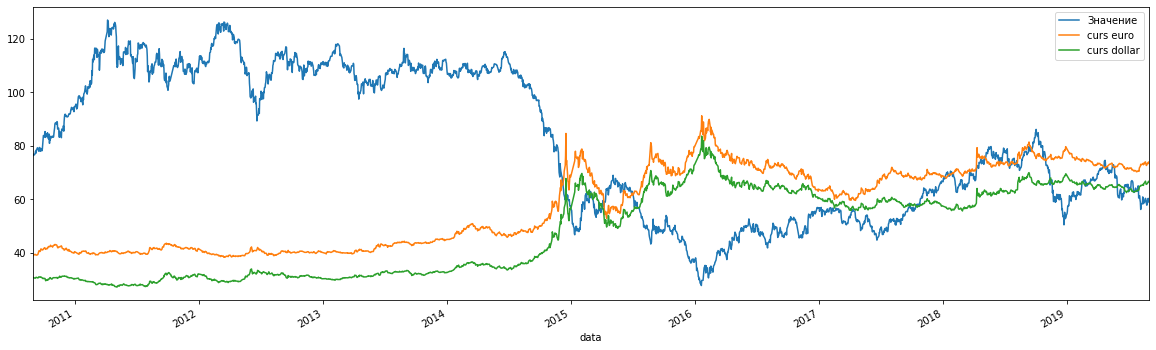

In [6]:
plt.figure(figsize=(20, 6))
brent_data['Значение'].plot()
rub_euro['curs euro'].plot()
rub_doll['curs dollar'].plot()
plt.legend()
plt.show()

#### Объединим данные по дате

In [7]:
brent_data = pd.concat([brent_data, rub_doll, rub_euro], axis=1)

In [8]:
np.sum(brent_data.isna())

Значение           470
year               470
month              470
dayofmonth         470
quarter            470
dayofyear          470
weekofyear         470
dayofweek          470
is_holiday         470
is_prev_holiday    470
is_next_holiday    470
curs dollar        909
curs euro          909
dtype: int64

Есть пропуски (дни без торговли). Посмотрим на них

In [9]:
ind_brent = np.where(brent_data['Значение'].isna() == True)[0]
brent_data.iloc[ind_brent[:5]]

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday,curs dollar,curs euro
2010-09-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31.0826,40.8115
2010-09-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.9480,41.2599
2010-10-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.5094,41.6606
2010-10-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.9086,41.6717
2010-10-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.1243,42.3939


Не торгуем раз в неделю (воскресенье)

In [10]:
ind_doll = np.where(brent_data['curs dollar'].isna() == True)[0]
brent_data.iloc[ind_doll[:5]]

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday,curs dollar,curs euro
2010-09-05,76.63,2010.0,9.0,5.0,3.0,248.0,35.0,6.0,0.0,1.0,0.0,NaN,NaN
2010-09-06,76.87,2010.0,9.0,6.0,3.0,249.0,36.0,0.0,1.0,0.0,0.0,NaN,NaN
2010-09-13,79.19,2010.0,9.0,13.0,3.0,256.0,37.0,0.0,0.0,0.0,0.0,NaN,NaN
2010-09-19,78.23,2010.0,9.0,19.0,3.0,262.0,37.0,6.0,0.0,0.0,0.0,NaN,NaN
2010-09-20,79.36,2010.0,9.0,20.0,3.0,263.0,38.0,0.0,0.0,0.0,0.0,NaN,NaN


In [11]:
ind_euro = np.where(brent_data['curs euro'].isna() == True)[0]
brent_data.iloc[ind_euro[:5]]

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday,curs dollar,curs euro
2010-09-05,76.63,2010.0,9.0,5.0,3.0,248.0,35.0,6.0,0.0,1.0,0.0,NaN,NaN
2010-09-06,76.87,2010.0,9.0,6.0,3.0,249.0,36.0,0.0,1.0,0.0,0.0,NaN,NaN
2010-09-13,79.19,2010.0,9.0,13.0,3.0,256.0,37.0,0.0,0.0,0.0,0.0,NaN,NaN
2010-09-19,78.23,2010.0,9.0,19.0,3.0,262.0,37.0,6.0,0.0,0.0,0.0,NaN,NaN
2010-09-20,79.36,2010.0,9.0,20.0,3.0,263.0,38.0,0.0,0.0,0.0,0.0,NaN,NaN


Похоже на отсутствие торговли воскресенье-понедельник (пока не закончен день - нет ккросс-курса)

#### Будем заполнять последним известным значением все пропуски

In [12]:
brent_data['curs dollar'].fillna(method='ffill', inplace=True)
brent_data['curs euro'].fillna(method='ffill', inplace=True)
brent_data['Значение'].fillna(method='ffill', inplace=True)

Поля календаря слабо влияют на значения этого ряда - исключаем их

In [13]:
brent_data = brent_data[['Значение', 'curs dollar', 'curs euro']]
brent_data.head()

,Значение,curs dollar,curs euro
2010-09-01,76.37,30.8669,39.0127
2010-09-02,76.89,30.8001,39.1654
2010-09-03,76.57,30.6858,39.2901
2010-09-04,76.62,30.6922,39.3505
2010-09-05,76.63,30.6922,39.3505


Сделаем ресемплинг на неделю

In [14]:
brent_data_w = brent_data.resample('W').mean()
brent_data_w.head()

,Значение,curs dollar,curs euro
2010-09-05,76.616000,30.747440,39.233840
2010-09-12,77.673333,30.777050,39.302883
2010-09-19,78.590000,30.887129,39.984557
2010-09-26,78.558571,31.003800,41.040657
2010-10-03,81.582857,30.585086,41.382686


In [15]:
brent_data_w.dropna(inplace=True)
brent_data_w.head()

,Значение,curs dollar,curs euro
2010-09-05,76.616000,30.747440,39.233840
2010-09-12,77.673333,30.777050,39.302883
2010-09-19,78.590000,30.887129,39.984557
2010-09-26,78.558571,31.003800,41.040657
2010-10-03,81.582857,30.585086,41.382686


In [16]:
adfuller(brent_data_w['Значение'], regression='ctt')

(-2.7898146819922545,
 0.40389846475586044,
 5,
 464,
 {'1%': -4.396274283817996,
  '5%': -3.8451769989336255,
  '10%': -3.561172289966388},
 1974.0745861660207)

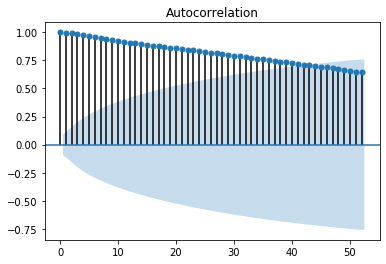

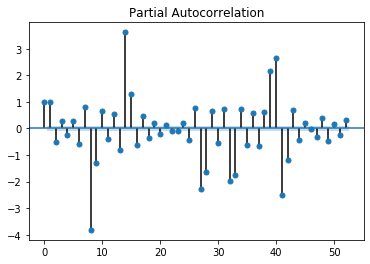

In [17]:
plot_acf(brent_data_w['Значение'], lags=52)
plt.show()

plot_pacf(brent_data_w['Значение'], lags=52)
plt.show()

Ряд нестационарный зависит от длинной истории (45 недель назад влияют на прогноз)

Добавляем первые разности (продифференцируем ряд)

In [18]:
brent_data_w['d_brent'] = brent_data_w['Значение'].diff(1)
brent_data_w['doll_brent'] = brent_data_w['curs dollar'].diff(1)
brent_data_w['euro_brent'] = brent_data_w['curs euro'].diff(1)
brent_data_w.dropna(inplace=True)  

Проверим разности на стационарность

In [19]:
adfuller(brent_data_w['d_brent'], regression='ctt')

(-13.687495282868001,
 2.5324714184050306e-22,
 1,
 467,
 {'1%': -4.396111652921828,
  '5%': -3.84509447012365,
  '10%': -3.5611212965378463},
 1975.107911794324)

P-value = 0 - ряд стационарен - Таким образом, порядок интегрирования 1

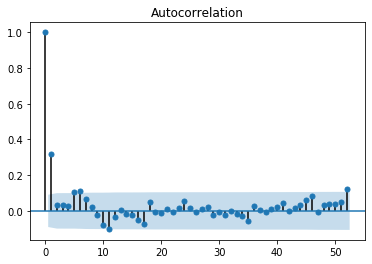

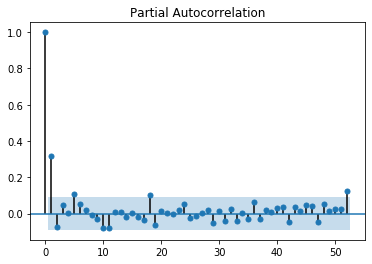

In [20]:
plot_acf(brent_data_w['d_brent'], lags=52)
plt.show()

plot_pacf(brent_data_w['d_brent'], lags=52)
plt.show()

Влияет только первое значение по глубине истории для разностей

### ARIMA

параметры

In [21]:
S = 0
d, D = 1, 0
p, P = 6, 0
q, Q = 6, 0

ps, Ps = np.arange(0, p + 1), np.arange(0, P + 1)
qs, Qs = np.arange(0, q + 1), np.arange(0, Q + 1)

In [22]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

49

#### Перебор параметров:

In [23]:
%%time
results = []
opt_aic = float('inf')
warnings.filterwarnings('ignore')

for n, param in enumerate(parameters_list):
    model=SARIMAX(brent_data_w['Значение'].values[330:427], order=(param[0], d, param[1]), 
                  seasonal_order=(param[2], D, param[3], S), 
                  enforce_stationarity=False ,
                  enforce_invertibility=False).fit(disp=-1)

    aic = model.aic
    if aic < opt_aic:
        opt_model = model
        opt_aic = aic
        opt_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

Wall time: 6.67 s


Топ-5 моделей

In [24]:
result_table = pd.DataFrame(results, columns=['parameters', 'aic'])
result_table.sort_values(by='aic', ascending=True).head()

,parameters,aic
6,"(0, 6, 0, 0)",353.156235
19,"(2, 5, 0, 0)",354.934157
5,"(0, 5, 0, 0)",355.112982
13,"(1, 6, 0, 0)",355.125658
20,"(2, 6, 0, 0)",355.903118


#### Лучшая модель

In [25]:
print(opt_model.summary())

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                   97
Model:               SARIMAX(0, 1, 6)   Log Likelihood                -169.578
Date:                Thu, 21 May 2020   AIC                            353.156
Time:                        14:21:13   BIC                            370.577
Sample:                             0   HQIC                           360.178
                                 - 97                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.3764      0.122      3.085      0.002       0.137       0.616
ma.L2          0.0136      0.126      0.108      0.914      -0.233       0.260
ma.L3         -0.0786      0.114     -0.688      0.4

#### Анализ остатков

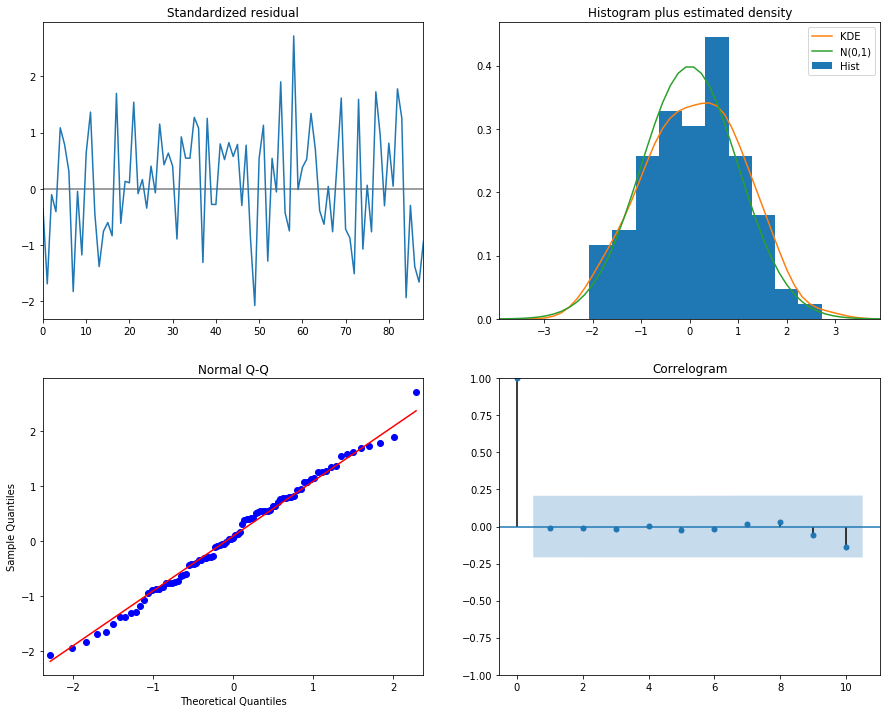

In [26]:
opt_model.plot_diagnostics(figsize=(15, 12))
plt.show()

Распределение остатков близко к нормальному. Остатки стационарны.


## Выводы по ARIMA

Таким образом, рабочая модель : 
   - q = 6 -  сглаживание
   - d = 1 - учитываем 1-е разности 
   - p = 0 - все значения для текущего момента 

   - сезона нет.


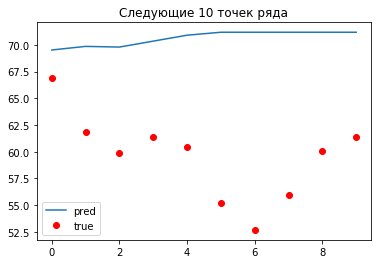

In [27]:
final_model=SARIMAX(brent_data_w['Значение'].values[350:427], 
                    order=(0, 1, 6), 
                    seasonal_order=(0, 0, 0, 0),
                    enforce_stationarity= False,
                    enforce_invertibility=False).fit(disp=-1)

pred_dynamic = final_model.forecast(10)    #делаем предсказание на 10 точки от текущего
 
plt.plot(pred_dynamic, label='pred')
plt.plot(brent_data_w['Значение'].values[427:437], 'or', label='true')
plt.title('Следующие 10 точек ряда')
plt.legend()
plt.plot()
plt.show()

In [28]:
p = 1
q = 6
h = 1



### Создание признаков

Берем сглаживание 
Текущее значение
текущее значение 1-й разности

In [29]:
brent_data_w['ma1']=brent_data_w['Значение'].rolling(q).mean()
brent_data_w = brent_data_w.iloc[1:]
brent_data_w.head()

,Значение,curs dollar,curs euro,d_brent,doll_brent,euro_brent,ma1
2010-09-19,78.590000,30.887129,39.984557,0.916667,0.110079,0.681674,NaN
2010-09-26,78.558571,31.003800,41.040657,-0.031429,0.116671,1.056100,NaN
2010-10-03,81.582857,30.585086,41.382686,3.024286,-0.418714,0.342029,NaN
2010-10-10,84.152857,30.112129,41.636057,2.570000,-0.472957,0.253371,NaN
2010-10-17,83.392857,30.017657,41.987514,-0.760000,-0.094471,0.351457,80.658413


In [30]:
for i in range(p):
    brent_data_w[f'p{i + 1}'] = 0
    brent_data_w[f'p{i + 1}'].values[p:] = brent_data_w['Значение'].values[p - i - 1:-i - 1]
    

brent_data_w.head()

,Значение,curs dollar,curs euro,d_brent,doll_brent,euro_brent,ma1,p1
2010-09-19,78.590000,30.887129,39.984557,0.916667,0.110079,0.681674,NaN,0
2010-09-26,78.558571,31.003800,41.040657,-0.031429,0.116671,1.056100,NaN,78
2010-10-03,81.582857,30.585086,41.382686,3.024286,-0.418714,0.342029,NaN,78
2010-10-10,84.152857,30.112129,41.636057,2.570000,-0.472957,0.253371,NaN,81
2010-10-17,83.392857,30.017657,41.987514,-0.760000,-0.094471,0.351457,80.658413,84


Будем  смотреть только на текущие значения (без глубины истории), 1-е разности и сглаживание по MA

Построим целевой признак и признаки для обучения:

In [31]:
brent_data_w.dropna(inplace=True)  
df = brent_data_w.iloc[p:-h, :].copy()
df['target'] = 0
df['target'] = brent_data_w.iloc[p+h:, 0].values.copy()
brent_data_w.dropna(inplace=True)    
df.head()

,Значение,curs dollar,curs euro,d_brent,doll_brent,euro_brent,ma1,p1,target
2010-10-24,82.810000,30.512871,42.491329,-0.582857,0.495214,0.503814,81.514524,83,83.330000
2010-10-31,83.330000,30.562071,42.509329,0.520000,0.049200,0.018000,82.304524,82,87.003333
2010-11-07,87.003333,30.777117,43.020217,3.673333,0.215045,0.510888,83.711984,83,87.552857
2010-11-14,87.552857,30.750257,42.485571,0.549524,-0.026860,-0.534645,84.706984,87,84.677143
2010-11-21,84.677143,31.029600,42.289557,-2.875714,0.279343,-0.196014,84.794365,87,85.177143


### Разделение данных на train и test

In [32]:
def split_data_b(df, split_date):
    return df.loc[df.index.get_level_values(df.index.name) <= split_date].copy(), \
           df.loc[df.index.get_level_values(df.index.name) > split_date].copy()

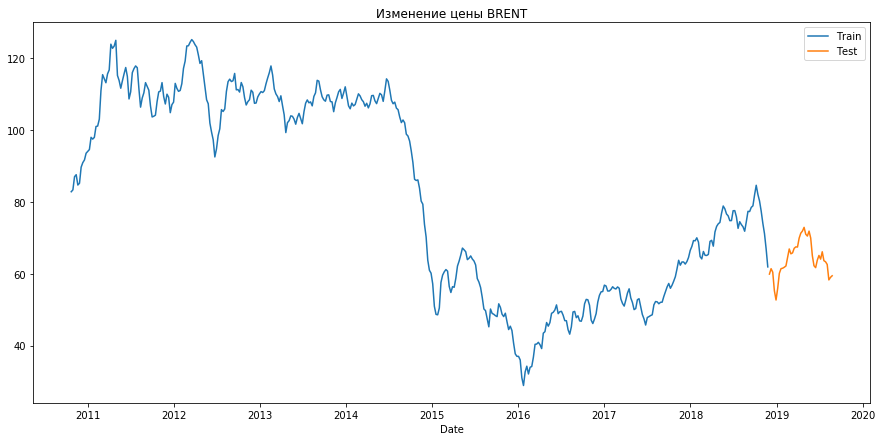

In [33]:
train, test = split_data_b(df, '2018-12-01')

plt.figure( figsize=(15, 7))
plt.plot(train.index,train.iloc[:, 0], label='Train')
plt.plot(test.index,test.iloc[:, 0], label='Test')
plt.xlabel('Date')
plt.title('Изменение цены BRENT')
plt.legend(loc='best')
plt.show()

In [34]:
X_train = train.iloc[:, :-1]
y_train = train.iloc[:, -1]

X_test = test.iloc[:, :-1]
y_test = test.iloc[:, -1]

In [35]:
X_train.shape

(423, 8)

### Обучение модели

In [36]:
model_g = GradientBoostingRegressor(max_depth=4, random_state=0, n_estimators=1250)

In [37]:
scx= StandardScaler().fit(X_train)
X_train_s = scx.transform(X_train)
X_test_s = scx.transform(X_test)

scy= StandardScaler().fit(y_train.values.reshape(y_train.shape[0], 1))
y_train_s = scy.transform(y_train.values.reshape(y_train.shape[0], 1))
y_test_s = scy.transform(y_test.values.reshape(y_test.shape[0], 1))

In [38]:
model_g.fit(X_train_s, y_train_s.ravel())

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=4,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=1250,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=0, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

### Прямое прогнозирование

#### Наиболее важные признаки:

In [39]:
feature_importances = pd.Series(model_g.feature_importances_, index=X_train.columns)
feature_importances.sort_values(ascending=False)

Значение       0.529197
curs euro      0.326506
curs dollar    0.137235
ma1            0.003732
d_brent        0.001566
euro_brent     0.000685
doll_brent     0.000675
p1             0.000404
dtype: float64

Самая сильная связь -текущее значение цены нефти и курс доллара :)

Следующий по силе признак - сглаживание цены

Исторические значения цены и разности значительно слабее при решении задачи предсказания как по курсам, так и по самой цене нефти 


## Прогноз

In [40]:
y_test_pred_s = model_g.predict(X_test_s)

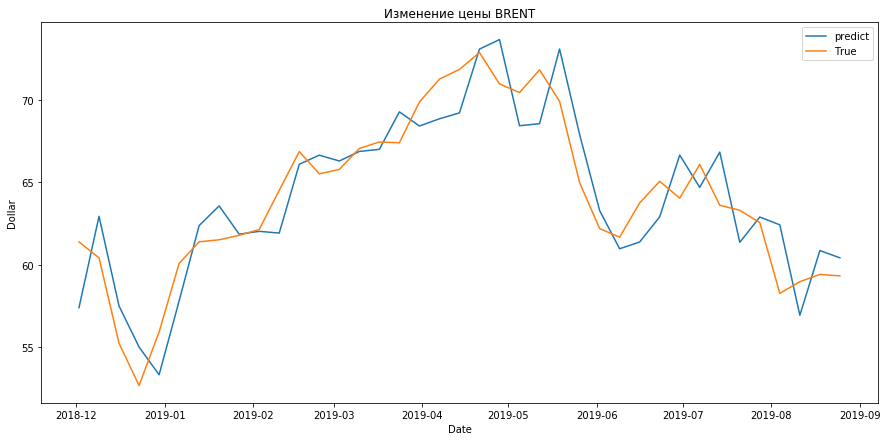

In [41]:
plt.figure( figsize=(15, 7))
plt.plot(test.index,scy.inverse_transform(y_test_pred_s), label='predict' )
plt.plot(test.index,scy.inverse_transform(y_test_s), label='True')
plt.xlabel('Date')
plt.title('Изменение цены BRENT')
plt.ylabel('Dollar')
plt.legend()
plt.show()

#### Ошибка

In [42]:
def MAPE(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    print(f'Ошибка градиентного бустинга MAPE: {np.mean(np.abs((y_true - y_pred) / y_true)) * 100}%')

In [43]:
MAPE(y_true=scy.inverse_transform(y_test_s),
     y_pred = scy.inverse_transform(y_test_pred_s))

Ошибка градиентного бустинга MAPE: 8.640574375762165%


Исключим курсы валют из прогноза, т.к. они коррелированы с текущим значением цены.

In [44]:
list_feat = np.array(range(p + 2)) + 6

df_rec=df.iloc[:, [0, 3] + list_feat.tolist()].copy()
df_rec.head()

,Значение,d_brent,ma1,p1,target
2010-10-24,82.810000,-0.582857,81.514524,83,83.330000
2010-10-31,83.330000,0.520000,82.304524,82,87.003333
2010-11-07,87.003333,3.673333,83.711984,83,87.552857
2010-11-14,87.552857,0.549524,84.706984,87,84.677143
2010-11-21,84.677143,-2.875714,84.794365,87,85.177143


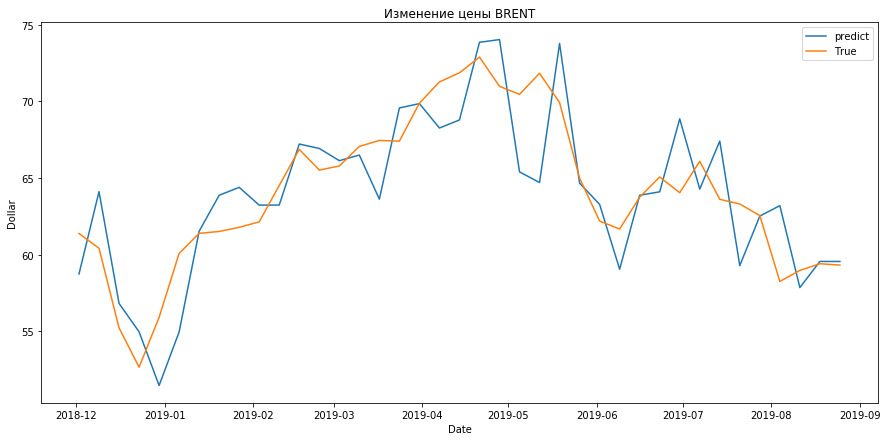

Ошибка градиентного бустинга MAPE: 8.819852664562916%


In [45]:
train_c, test_c = split_data_b(df_rec, '2018-12-01')

X_train_c = train_c.iloc[:, :-1]
y_train_c = train_c.iloc[:, -1]
X_test_c = test_c.iloc[:, :-1]
y_test_c = test_c.iloc[:, -1]

model_gc = GradientBoostingRegressor(max_depth=10, random_state=0, n_estimators=1550)

scxc= StandardScaler().fit(X_train_c)
X_train_cs = scxc.transform(X_train_c)
X_test_cs = scxc.transform(X_test_c)

scyc= StandardScaler().fit(y_train_c.values.reshape(y_train_c.shape[0], 1))
y_train_cs = scyc.transform(y_train_c.values.reshape(y_train_c.shape[0], 1))
y_test_cs = scyc.transform(y_test_c.values.reshape(y_test_c.shape[0], 1))

model_gc.fit(X_train_cs, y_train_cs.ravel())


y_test_pred_cs = model_gc.predict(X_test_cs)


plt.figure( figsize=(15, 7))
plt.plot(test_c.index,scyc.inverse_transform(y_test_pred_cs), label='predict' )
plt.plot(test_c.index,scyc.inverse_transform(y_test_cs), label='True')
plt.xlabel('Date')
plt.title('Изменение цены BRENT')
plt.ylabel('Dollar')
plt.legend()
plt.show()

MAPE(y_true=scyc.inverse_transform(y_test_cs),
     y_pred = scyc.inverse_transform(y_test_pred_cs))

Ошибка модели несколько больше, но нет внешних факторов (курсов валют). Можем построить рекурсивную модель 

### Рекурсивное прогнозирование


In [46]:
x_shape = X_train_c.shape[0]

In [47]:
df_rec.head() 

,Значение,d_brent,ma1,p1,target
2010-10-24,82.810000,-0.582857,81.514524,83,83.330000
2010-10-31,83.330000,0.520000,82.304524,82,87.003333
2010-11-07,87.003333,3.673333,83.711984,83,87.552857
2010-11-14,87.552857,0.549524,84.706984,87,84.677143
2010-11-21,84.677143,-2.875714,84.794365,87,85.177143


In [48]:
print(X_test_c.iloc[0])

Значение    59.882857
d_brent     -2.002857
ma1         68.550000
p1          61.000000
Name: 2018-12-02 00:00:00, dtype: float64


#### Начало исходной тестовой части данных для рекурсивной модели:

In [49]:
ind_test = np.where(df_rec.index.get_level_values(df_rec.index.name) == '2019-01-06')[0][0]
df_rec_test = df_rec.iloc[ind_test - q + 1:].copy()
df_rec_test.head(5 + q)

,Значение,d_brent,ma1,p1,target
2018-12-02,59.882857,-2.002857,68.550000,61,61.390000
2018-12-09,61.390000,1.507143,65.877381,59,60.422857
2018-12-16,60.422857,-0.967143,63.606905,61,55.232857
2018-12-23,55.232857,-5.190000,60.953095,60,52.668571
2018-12-30,52.668571,-2.564286,58.580476,55,55.916000
2019-01-06,55.916000,3.247429,57.585524,52,60.085714
2019-01-13,60.085714,4.169714,57.619333,55,61.395714
2019-01-20,61.395714,1.310000,57.620286,60,61.520000
2019-01-27,61.520000,0.124286,57.803143,61,61.791429
2019-02-03,61.791429,0.271429,58.896238,61,62.145714


In [50]:
df_rec_test.shape

(39, 5)

#### Рекурсии (обновление ):

In [51]:
h_step = 20  # число шагов модели в рекурсивной форме

for i in range(h_step):
    f_w = scxc.transform(df_rec_test.iloc[i + q, :-1].values.reshape(1, 4))
    df_rec_test.iloc[i + q + 1, 0] = scyc.inverse_transform(model_gc.predict(f_w))[0]
    df_rec_test.iloc[i + q + 1, 1] = df_rec_test.iloc[i + q + 1, 0] - df_rec_test.iloc[i + q, 0] 
    df_rec_test.iloc[i + q + 1, 2] = np.mean(df_rec_test.iloc[i + 1:i + q + 1, 0] )
    df_rec_test.iloc[i + q + 1, 2] = df_rec_test.iloc[i + q, 0] 

In [52]:
df_rec_test.head(5 + q)

,Значение,d_brent,ma1,p1,target
2018-12-02,59.882857,-2.002857,68.550000,61,61.390000
2018-12-09,61.390000,1.507143,65.877381,59,60.422857
2018-12-16,60.422857,-0.967143,63.606905,61,55.232857
2018-12-23,55.232857,-5.190000,60.953095,60,52.668571
2018-12-30,52.668571,-2.564286,58.580476,55,55.916000
2019-01-06,55.916000,3.247429,57.585524,52,60.085714
2019-01-13,60.085714,4.169714,57.619333,55,61.395714
2019-01-20,61.533921,1.448207,60.085714,60,61.520000
2019-01-27,63.247790,1.713869,61.533921,61,61.791429
2019-02-03,63.251929,0.004139,63.247790,61,62.145714


In [53]:
scyc.inverse_transform(y_test_pred_cs[:20])

array([58.74619714, 64.11896273, 56.82831092, 54.97678729, 51.47252287,
       54.96405501, 61.53392098, 63.88149083, 64.3977751 , 63.23831398,
       63.24417797, 67.22329596, 66.93572395, 66.13880597, 66.50346934,
       63.62667106, 69.57471657, 69.8613717 , 68.26844051, 68.79386209])

#### h_step тестовых отсчетов:

- прямое прогнозирование (GB);
- рекурсивное прогнозирование (GB with recursion).

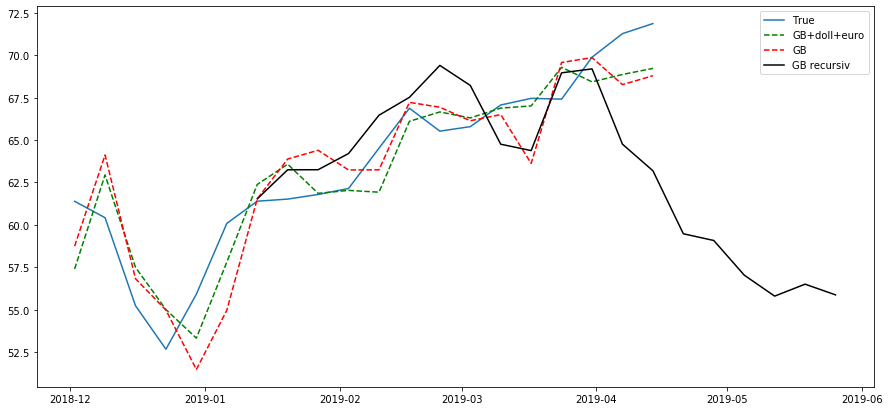

In [54]:
plt.figure(figsize=(15, 7))

plt.plot(y_test.index[:h_step], y_test.values[:h_step], label='True')
plt.plot(y_test.index[:h_step], scy.inverse_transform(y_test_pred_s[:h_step]), '--g', label='GB+doll+euro')
plt.plot(y_test.index[:h_step], scyc.inverse_transform(y_test_pred_cs[:h_step]), '--r', label='GB')
plt.plot(df_rec_test.index[q:h_step + q], df_rec_test.iloc[1 + q:h_step + q + 1, 0].values, 'k', label='GB recursiv')

plt.legend()
plt.show()

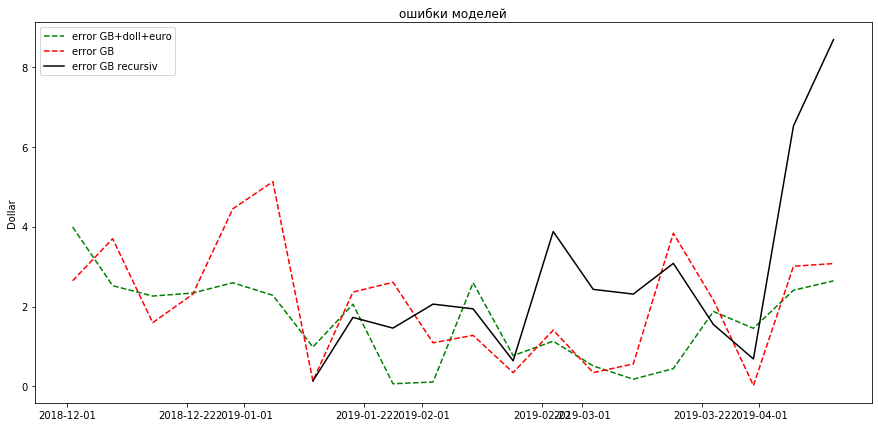

In [55]:
plt.figure(figsize=(15, 7))

plt.plot(y_test.index[:h_step], 
         np.abs(scy.inverse_transform(y_test_pred_s[:h_step]) - y_test.values[:h_step]),
         '--g', label='error GB+doll+euro')
plt.plot(y_test.index[:h_step], 
         np.abs(scyc.inverse_transform(y_test_pred_cs[:h_step]) - y_test.values[:h_step]),
         '--r', label='error GB')
plt.plot(df_rec_test.index[q:h_step], 
         np.abs(df_rec_test.iloc[1 + q:h_step + 1, 0].values - y_test.values[q:h_step]),
         'k', label='error GB recursiv')

plt.title('ошибки моделей')
plt.ylabel('Dollar')
plt.legend()
plt.show()

**Вывод:**  

Курс валюты связан с ценой нефти, но скорее зависит от нее.Поэтому ряд с учетом курса и без него работает практически одинаково.

Рекурсивный прогноз слабее, но тенденцию ряда видимт дальше, чем на p - истории (в нашем случае пока есть монотонность). Рекурсивный прогноз хорошо работает в рядах с выраженными временными связями (например "Потребление энергии")

Посмотрим на другой горизонт прогноза h = 10

## Изменим h (h=10)

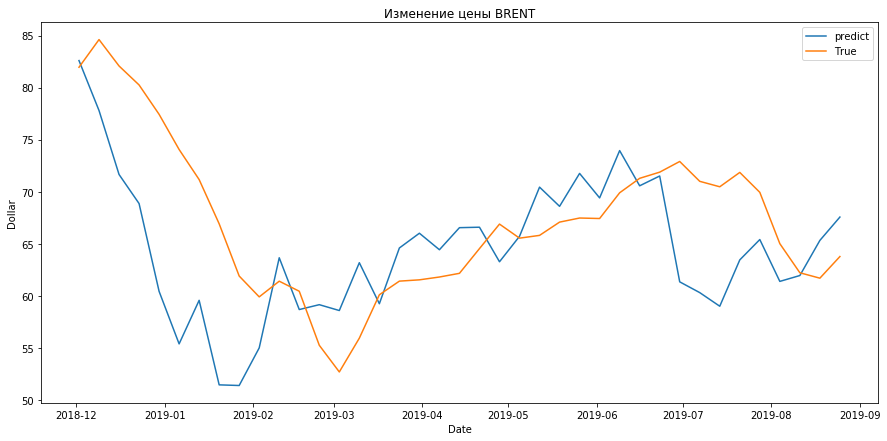

Ошибка градиентного бустинга MAPE: 11.704905973941901%


In [56]:
h_10 = 10
    
df_rec10 = df_rec.copy()
df_rec10['target'].values[h_10:] = df_rec10['target'].values[:-h_10]

train_c10, test_c10 = split_data_b(df_rec10, '2018-12-01')

X_train_c10 = train_c10.iloc[:, :-1]
y_train_c10 = train_c10.iloc[:, -1]
X_test_c10 = test_c10.iloc[:, :-1]
y_test_c10 = test_c10.iloc[:, -1]

model_gc10 = GradientBoostingRegressor(max_depth=4, random_state=0, n_estimators=1050)

scxc10= StandardScaler().fit(X_train_c10)
X_train_cs10 = scxc10.transform(X_train_c10)
X_test_cs10 = scxc10.transform(X_test_c10)

scyc10= StandardScaler().fit(y_train_c10.values.reshape(y_train_c10.shape[0], 1))
y_train_cs10 = scyc10.transform(y_train_c10.values.reshape(y_train_c10.shape[0], 1))
y_test_cs10 = scyc10.transform(y_test_c10.values.reshape(y_test_c10.shape[0], 1))

model_gc10.fit(X_train_cs10, y_train_cs10.ravel())


y_test_pred_cs10 = model_gc10.predict(X_test_cs10)


plt.figure( figsize=(15, 7))
plt.plot(test_c10.index,scyc10.inverse_transform(y_test_pred_cs10), label='predict' )
plt.plot(test_c10.index,scyc10.inverse_transform(y_test_cs10), label='True')
plt.xlabel('Date')
plt.title('Изменение цены BRENT')
plt.ylabel('Dollar')
plt.legend()
plt.show()

MAPE(y_true=scyc10.inverse_transform(y_test_cs10),
     y_pred=scyc10.inverse_transform(y_test_pred_cs10))

## Вывод

Изменяем горизонт прогноза

     - при увеличении h имеет смысл строить более общую модель (понизить высоту деревьев)
     - ошибка тем больше, чем дальше прогноз по h
     - видно запаздывание модели

## Прогнозирование  по первым разностям

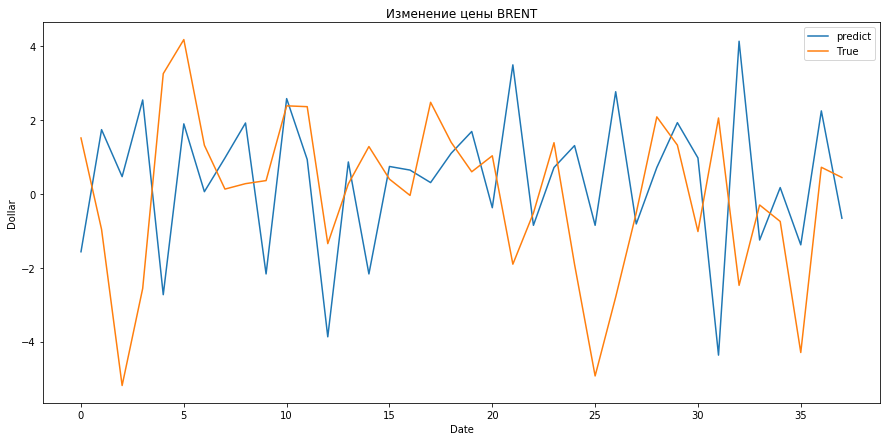

Ошибка градиентного бустинга MAE: 26.96623584195719


In [57]:
train_d, test_d = split_data_b(df_rec.iloc[:, 1], '2018-12-01')
# делаем прогноз только для небольшой части ряда, т.к. помним, что ряд менял свою дисперсию в 2015 и 2016 годах

X_train_d = train_d.iloc[:-h].values
y_train_d = train_d.iloc[h:].values
X_test_d = test_d.iloc[:-h].values
y_test_d = test_d.iloc[h:].values

model_gd = GradientBoostingRegressor(max_depth=10, random_state=0, n_estimators=1550)

scxd = StandardScaler().fit(X_train_d.reshape(y_train_d.shape[0], 1))
X_train_ds = scxd.transform(X_train_d.reshape(y_train_d.shape[0], 1))
X_test_ds = scxd.transform(X_test_d.reshape(y_test_d.shape[0], 1))

scyd = StandardScaler().fit(y_train_d.reshape(y_train_d.shape[0], 1))
y_train_ds = scyd.transform(y_train_d.reshape(y_train_d.shape[0], 1))
y_test_ds = scyd.transform(y_test_d.reshape(y_test_d.shape[0], 1))

model_gd.fit(X_train_ds, y_train_ds.ravel())

y_test_pred_ds = model_gd.predict(X_test_ds)

plt.figure(figsize=(15, 7))
plt.plot(scyd.inverse_transform(y_test_pred_ds), label='predict')
plt.plot(scyd.inverse_transform(y_test_ds), label='True')

plt.xlabel('Date')
plt.ylabel('Dollar')

plt.title('Изменение цены BRENT')

plt.legend()
plt.show()

er_g = np.abs(scyc.inverse_transform(y_test_ds) - scyc.inverse_transform(y_test_pred_ds)).mean()
print(f'Ошибка градиентного бустинга MAE: {er_g}')

## Вывод  

Прогнозное значение модели не выходит за границы изменений ряда первых разностей далеко  :

- модель ряда в первых разностях - стационарна,
- можно предсказать диапазон случайных положений первых разностей, но не их конкретное значение. 

Такой ряд описывают его статистиками. Это случайные биения.